# Connect to DB, Fetch data

In [1]:
import pandas as pd
# specify connection to database
import psycopg2
connection = psycopg2.connect(
    host="nursedash-prod.cuzi2kducsnv.us-east-1.rds.amazonaws.com",
    database="nursedash",
    user="external_analyst",
    password="uDps8APganhSLc3K2xe7NtMPq")

### <font color = green> all time to chicago time, No withdrawn info

In [2]:
df = pd.read_sql_query("""

SELECT  sa.id, sa.user_id, sa.shift_id, f.id AS facility_id, sa."withdrawnInfo" -> 'initiator' as withdrawnInfo_value,
sa."status", sa."prevStatus", sa."distance", s."facility_id", "s"."description" AS "shift_description",
"s"."assigned_nurse_id", s."net_pay", "s"."unit" AS "s_unit",s."type",
"s"."qualifications" AS "s_qualifications", "s"."breakTime" AS "s_breakTime", sa."withdrawnInfo",
"f"."name" AS "f_name","f"."short_name" AS "f_short_name", f."segmentName", f."areaName",
timezone('America/Chicago', s."createdAt") as s_create,
timezone('America/Chicago', sa."createdAt") as sa_create,
timezone('America/Chicago', u."approvedAt") as u_approve,
timezone('America/Chicago', u."createdAt") as u_create,
timezone('America/Chicago', sa."statusUpdatedAt") as sa_statusUpdate,
timezone('America/Chicago', timezone('UTC', s.start_time)) AS "Start_Time" 
FROM shifts s
INNER JOIN shift_applications sa ON s.id = sa.shift_id
INNER JOIN facilities f ON s.facility_id = f.id
INNER JOIN users u ON sa.user_id = u.id

""", con = connection)

In [3]:
df.columns

Index(['id', 'user_id', 'shift_id', 'facility_id', 'withdrawninfo_value',
       'status', 'prevStatus', 'distance', 'facility_id', 'shift_description',
       'assigned_nurse_id', 'net_pay', 's_unit', 'type', 's_qualifications',
       's_breakTime', 'withdrawnInfo', 'f_name', 'f_short_name', 'segmentName',
       'areaName', 's_create', 'sa_create', 'u_approve', 'u_create',
       'sa_statusupdate', 'Start_Time'],
      dtype='object')

### 2 new columns to determine target

In [4]:
# CW_Time2Start_Time
df['CW_Time2Start_Time'] = df.apply(lambda row: (row['Start_Time'] - row['sa_statusupdate']).total_seconds()/3600 if str(row['Start_Time'])[:2] != '00' else 9999, 
                                         axis = 1)

# Target
def CW_by_nurse(row):
    if row['status']=='withdrawn' and row['prevStatus'] == 'confirmed':
        if row['CW_Time2Start_Time'] <= 24:
            return "UCW"
        else:
            return "CW"
    else:
        return 0
    
df['target'] = df.apply (lambda row: CW_by_nurse(row), axis=1)

# combine the prediction file with real data

In [5]:
# read the prediction file
prediction = pd.read_csv('pred_2021-4-11_Silver_Bullet.csv')
validation = prediction.merge(df, on = 'id', how = 'left')

In [6]:
validation['target'].value_counts()

0      685
CW      53
UCW     32
Name: target, dtype: int64

In [7]:
from datetime import date

today = date.today()

# convert to datetime for conditonal selection
validation['Start_Time_x'] = pd.to_datetime(validation['Start_Time_x'])

# record as realdata
validation['Study Set'] = validation['Start_Time_x'].apply(lambda x: "Y" if x <= today else "N")

In [8]:
validation = validation.rename(columns={"Start_Time_x": "Start_Time"})
validation = validation[['id','prob','target','Study Set','Start_Time','status','type','prevStatus', 'withdrawnInfo','areaName','segmentName']]

In [9]:
validation = validation.set_index("id")
validation.columns

Index(['prob', 'target', 'Study Set', 'Start_Time', 'status', 'type',
       'prevStatus', 'withdrawnInfo', 'areaName', 'segmentName'],
      dtype='object')

## Output validation file

In [10]:
# read excel and save to a particular worksheet & it will help update the pivot table
import pandas

from openpyxl import load_workbook

book = load_workbook('analysis_2021-4-11_Silver_Bullet.xlsx')

writer = pandas.ExcelWriter('analysis_2021-4-11_Silver_Bullet.xlsx', engine='openpyxl') 

writer.book = book

writer.sheets = dict((ws.title, ws) for ws in book.worksheets)

validation.to_excel(writer, sheet_name='validation data')

writer.save()

In [11]:
validation.to_excel('analysis_2021-4-11_Silver_Bullet.xlsx')

## Validation

In [12]:
validation_Y = validation[validation['Study Set']=='Y']

In [35]:
from sklearn.metrics import classification_report, confusion_matrix

target = validation_Y['target'].apply(lambda row:1 if row == "UCW" else 0)
# test threshold
limiter = .50

y_prob = list(validation_Y['prob'])
y_pred = []
count =0
for prob in y_prob:
    if prob >= limiter:
        y_pred.append(1)
        count+=1
    else:
        y_pred.append(0)

print(classification_report(target, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.57      0.71       255
           1       0.13      0.55      0.21        29

    accuracy                           0.57       284
   macro avg       0.52      0.56      0.46       284
weighted avg       0.84      0.57      0.65       284



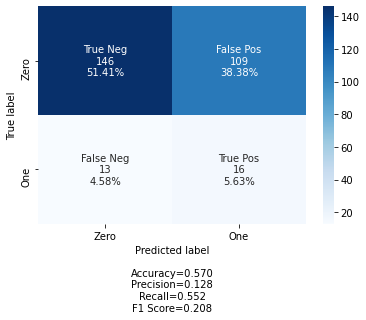

In [36]:
from cf_matrix import make_confusion_matrix
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(confusion_matrix(target, y_pred), 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [37]:
from sklearn.metrics import recall_score

label_coverage = y_pred.count(1)/len(y_pred)
UCW_coverage = recall_score(target, y_pred)

print('The limiter we adopt is %.2f' % (limiter))
print('By covering %.3f labeled as high probability of UCW, we have prepared for %.3f of real UCW' 
      % (label_coverage,UCW_coverage))

The limiter we adopt is 0.50
By covering 0.440 labeled as high probability of UCW, we have prepared for 0.552 of real UCW
